In [ ]:
!pip install pycocotools

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/farelptraalbana/klasifikasi-sampah.git

Cloning into 'klasifikasi-sampah'...
remote: Enumerating objects: 3010, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 3010 (delta 0), reused 0 (delta 0), pack-reused 3009 (from 3)
Receiving objects: 100% (3010/3010), 90.72 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Updating files: 100% (12163/12163), done.


In [3]:
%cd /content/klasifikasi-sampah

/content/klasifikasi-sampah


### **SPLIT TRAIN DAN TESTING DATASET**

In [ ]:
!pip install split-folders

In [ ]:
import json
import os
import shutil
import random
from google.colab import drive

def split_coco_dataset(coco_json_path, output_dir, image_dir, ratio=(0.8, 0.2)):
    """
    Membagi dataset COCO menjadi training dan testing set.
    """
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Mendapatkan daftar image ID dan file_name
    image_data = coco_data['images']
    image_ids = [img['id'] for img in image_data]
    file_names = [img['file_name'] for img in image_data]

    # Membagi image ID menjadi training dan testing
    random.seed(42)  # Untuk memastikan pembagian yang konsisten
    random.shuffle(image_ids)  # Acak image_ids

    train_size = int(len(image_ids) * ratio[0])
    train_ids = image_ids[:train_size]
    test_ids = image_ids[train_size:]

    # Membuat direktori output jika belum ada
    os.makedirs(os.path.join(output_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', 'images'), exist_ok=True)

    # Membagi data dan menyimpan ke file JSON baru
    def create_subset_json(ids, subset_name):
        subset_data = {
            'images': [img for img in coco_data['images'] if img['id'] in ids],
            'annotations': [ann for ann in coco_data['annotations'] if ann['image_id'] in ids],
            'categories': coco_data['categories']
        }
        with open(os.path.join(output_dir, subset_name, f'coco_annotations_{subset_name}.json'), 'w') as f:
            json.dump(subset_data, f, indent=4)

    create_subset_json(train_ids, 'train')
    create_subset_json(test_ids, 'test')

    # Split Image
    def split_images(image_ids, directory):
        for id in image_ids:
            # Get the file_name corresponding to the current id
            file_name = next((img['file_name'] for img in image_data if img['id'] == id), None)

            if file_name is not None and os.path.exists(os.path.join(image_dir, file_name)):
                source_path = os.path.join(image_dir, file_name)
                destination_path = os.path.join(output_dir, directory, 'images', file_name)
                shutil.copy(source_path, destination_path)

    split_images(train_ids, 'train')
    split_images(test_ids, 'test')

    print(f"Dataset berhasil dibagi dan disimpan di {output_dir}")

# Panggil Fungsi Split dengan rasio 80% train, 20% test
split_coco_dataset(
    '/content/klasifikasi-sampah/debris_dataset_880_augment/anotations/dataset.json',  # Path ke file JSON
    'debris_dataset_split_880_augment',  # Direktori output
    '/content/klasifikasi-sampah/debris_dataset_880_augment/images',  # Direktori gambar (image_dir)
    ratio=(0.8, 0.2)  # Rasio pembagian
)

# Salin folder ke Google Drive
destination_path = '/content/drive/MyDrive/SKRIPSI/pre_trained_model/debris_dataset_split_880_augment'  # Ganti dengan path tujuan di Drive
shutil.copytree('debris_dataset_split_880_augment', destination_path, dirs_exist_ok=True)
print(f"Folder 'debris_dataset_split_880_augment' berhasil disalin ke {destination_path}")

Dataset berhasil dibagi dan disimpan di debris_dataset_split_880_augment
Folder 'debris_dataset_split_880_augment' berhasil disalin ke /content/drive/MyDrive/SKRIPSI/pre_trained_model/debris_dataset_split_880_augment


### **Cek Kesesuaian Anotasi Label Dataset Training dan Testing**

In [4]:
import json
import os

def validate_coco_annotation_file(file_path):
    """
    Validasi struktur dasar file annotasi COCO
    """
    try:
        with open(file_path, 'r') as f:
            coco_data = json.load(f)

        # Cek keberadaan kunci utama
        required_keys = ['images', 'annotations', 'categories']
        for key in required_keys:
            if key not in coco_data:
                print(f"❌ Missing key: {key}")
                return False

        # Validasi images
        print(f"📸 Total Images: {len(coco_data['images'])}")

        # Validasi annotations
        print(f"🏷️ Total Annotations: {len(coco_data['annotations'])}")

        # Validasi categories
        print(f"🏷️ Total Categories: {len(coco_data['categories'])}")

        return True
    except json.JSONDecodeError:
        print("❌ Invalid JSON format")
        return False
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

def compare_coco_annotation_files(train_file, test_file):
    """
    Membandingkan struktur dan kategori antara file training dan testing
    """
    with open(train_file, 'r') as f_train:
        train_data = json.load(f_train)

    with open(test_file, 'r') as f_test:
        test_data = json.load(f_test)

    # Bandingkan kategori
    train_categories = {cat['name'] for cat in train_data['categories']}
    test_categories = {cat['name'] for cat in test_data['categories']}

    print("🔍 Kategori Perbandingan:")
    print(f"Kategori Training: {train_categories}")
    print(f"Kategori Testing: {test_categories}")

    if train_categories != test_categories:
        print("❌ Kategori TIDAK KONSISTEN!")
        print("Perbedaan Kategori:")
        print("Hanya ada di Training:", train_categories - test_categories)
        print("Hanya ada di Testing:", test_categories - train_categories)
        return False

    print("✅ Kategori KONSISTEN")

    # Bandingkan struktur
    train_image_ids = {img['id'] for img in train_data['images']}
    test_image_ids = {img['id'] for img in test_data['images']}

    print(f"\n📊 Total Image ID Training: {len(train_image_ids)}")
    print(f"📊 Total Image ID Testing: {len(test_image_ids)}")

    # Cek overlap image ID
    overlap_ids = train_image_ids.intersection(test_image_ids)
    if overlap_ids:
        print(f"⚠️ Peringatan: Ada {len(overlap_ids)} Image ID yang sama di training dan testing")

    return True

def check_annotation_distribution(file_path):
    """
    Mengecek distribusi annotasi per kategori
    """
    with open(file_path, 'r') as f:
        coco_data = json.load(f)

    # Hitung distribusi annotasi
    category_counts = {}
    for annotation in coco_data['annotations']:
        category_id = annotation['category_id']
        category_name = next(cat['name'] for cat in coco_data['categories'] if cat['id'] == category_id)

        if category_name not in category_counts:
            category_counts[category_name] = 0
        category_counts[category_name] += 1

    print("📊 Distribusi Annotasi per Kategori:")
    for category, count in category_counts.items():
        print(f"{category}: {count} annotasi")

    return category_counts

def main_debug():
    train_annotation_file = "debris_dataset_split_600/train/coco_annotations_train.json"
    test_annotation_file = "debris_dataset_split_600/test/coco_annotations_test.json"

    print("=== Validasi File Training ===")
    validate_coco_annotation_file(train_annotation_file)

    print("\n=== Validasi File Testing ===")
    validate_coco_annotation_file(test_annotation_file)

    print("\n=== Perbandingan Kategori ===")
    compare_coco_annotation_files(train_annotation_file, test_annotation_file)

    print("\n=== Distribusi Annotasi Training ===")
    check_annotation_distribution(train_annotation_file)

    print("\n=== Distribusi Annotasi Testing ===")
    check_annotation_distribution(test_annotation_file)

if __name__ == "__main__":
    main_debug()

=== Validasi File Training ===
📸 Total Images: 640
🏷️ Total Annotations: 1481
🏷️ Total Categories: 4

=== Validasi File Testing ===
📸 Total Images: 160
🏷️ Total Annotations: 197
🏷️ Total Categories: 4

=== Perbandingan Kategori ===
🔍 Kategori Perbandingan:
Kategori Training: {'Kantong Plastik', 'Bungkus Minuman', 'Botol Plastik', 'Bungkus Makanan'}
Kategori Testing: {'Kantong Plastik', 'Bungkus Minuman', 'Botol Plastik', 'Bungkus Makanan'}
✅ Kategori KONSISTEN

📊 Total Image ID Training: 640
📊 Total Image ID Testing: 160
⚠️ Peringatan: Ada 160 Image ID yang sama di training dan testing

=== Distribusi Annotasi Training ===
📊 Distribusi Annotasi per Kategori:
Bungkus Minuman: 413 annotasi
Botol Plastik: 237 annotasi
Bungkus Makanan: 383 annotasi
Kantong Plastik: 448 annotasi

=== Distribusi Annotasi Testing ===
📊 Distribusi Annotasi per Kategori:
Botol Plastik: 38 annotasi
Kantong Plastik: 63 annotasi
Bungkus Minuman: 48 annotasi
Bungkus Makanan: 48 annotasi


### **Import Library Yang Diperlukan**

In [5]:
# Imports
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import pandas as pd
import cv2
import json

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from engine import train_one_epoch, evaluate
from coco_eval import CocoEvaluator
import utils
import transforms as T

import seaborn as sns
from tqdm import tqdm

### **Parameter Yang Dibutuhkan**

In [6]:
# Hyperparameters
train_batch_size = 8  		 # Train batch size
test_batch_size = 8    		 # Test batch size
num_classes = 5        		 # Number of classes + background
learning_rate = 0.01  		 # Learning rate
num_epochs = 50      	     # Number of epochs
save_path = '/content/drive/MyDrive/SKRIPSI-FAREL/pre-trained_model/resnet_50/dataset_600/model_50_epoch_resnet'

### **Cek Jika Dataset Merupakan Format .csv**

In [7]:
def csv_to_coco(csv_path, json_output_path):
    """
    Mengonversi CSV annotations menjadi format COCO JSON
    """
    df = pd.read_csv(csv_path)

    images = []
    annotations = []
    categories = []

    image_id = 0
    annotation_id = 0
    category_dict = {}
    for _, row in df.iterrows():
        # Tambahkan image
        image_name = row['filename']
        if image_name not in [img['file_name'] for img in images]:
            images.append({
                "id": image_id,
                "file_name": image_name,
                "width": row['width'],
                "height": row['height']
            })
            current_image_id = image_id
            image_id += 1
        else:
            current_image_id = next(img['id'] for img in images if img['file_name'] == image_name)

        # Tambahkan categories
        class_name = row['class']
        if class_name not in category_dict:
            category_id = len(category_dict) + 1
            category_dict[class_name] = category_id
            categories.append({"id": category_id, "name": class_name})

        # Tambahkan annotations
        annotations.append({
            "id": annotation_id,
            "image_id": current_image_id,
            "bbox": [row['xmin'], row['ymin'], row['xmax'] - row['xmin'], row['ymax'] - row['ymin']],
            "category_id": category_dict[class_name],
            "area": (row['xmax'] - row['xmin']) * (row['ymax'] - row['ymin']),
            "iscrowd": 0
        })
        annotation_id += 1

    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(json_output_path, 'w') as f:
        json.dump(coco_output, f, indent=4)

### **Cek Label Apakah Sesuai atau Tidak**

In [8]:
def create_labels_dict_from_coco(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    labels_dict = {category["id"] : category["name"] for category in coco_data["categories"]}

    with open('labels1.txt', 'w') as f:
        json.dump(labels_dict, f)

    return labels_dict

# Call the function to create the labels_dict
labels_dict = create_labels_dict_from_coco("debris_dataset_split_600/train/coco_annotations_train.json")  # Or your desired path

print(labels_dict)


def parse_coco_annotation(coco_json_path, image_id):
    """
    Parsing anotasi COCO untuk ID gambar tertentu

    Args:
        coco_json_path (str): Path ke file JSON COCO
        image_id (int): ID gambar yang ingin diambil annotasinya

    Returns:
        tuple: Daftar bounding boxes dan label
    """
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    boxes = []
    labels = []

    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            bbox = annotation['bbox']  # [x, y, width, height]
            xmin, ymin, width, height = bbox
            xmax = xmin + width
            ymax = ymin + height

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(annotation['category_id'])

    return boxes, labels

{1: 'Botol Plastik', 2: 'Bungkus Makanan', 3: 'Bungkus Minuman', 4: 'Kantong Plastik'}


### **Inisialisasi Kelas Coco Dataset**

In [9]:
class CocoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset untuk memuat data COCO
    """
    def __init__(self, dataset_dir, annotation_file):
        self.dataset_dir = dataset_dir
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.dataset_dir, image_info['file_name'])

        # Muat gambar
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Muat annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Validate bounding box coordinates
            if bbox[0] < 0 or bbox[1] < 0 or bbox[0] + bbox[2] > image_info['width'] or bbox[1] + bbox[3] > image_info['height']:
                print(f"Warning: Invalid bounding box coordinates for image ID {image_id}, annotation ID {ann['id']}. Skipping this annotation.")
                continue  # Skip this annotation if it's invalid

            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann['category_id'])

        # Konversi ke tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure boxes and labels are not empty and labels are within the valid range
        if boxes.shape[0] == 0 or labels.shape[0] == 0 or any(label.item() < 0 or label.item() >= num_classes for label in labels):
            print(f"Warning: Invalid annotations (empty or out of range) found for image ID {image_id}. Skipping this image.")
            return None, None  # Return None to indicate an empty sample

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": torch.tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.zeros((len(anns),), dtype=torch.int64)
        }

        image = torch.from_numpy(image).float() / 255.0
        image = image.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return image, target

    def __len__(self):
        return len(self.image_ids)

### **Visualisasi Dataset Yang Sesuai**

In [10]:
def visualize_dataset_samples(dataset, labels_dict, num_samples=2):
    """
    Memvisualisasikan sampel dataset dengan bounding box dan label kelas

    Args:
        dataset (torch.utils.data.Dataset): Dataset yang akan divisualisasikan
        labels_dict (dict): Dictionary mapping label ID ke nama kelas
        num_samples (int, optional): Jumlah sampel yang akan ditampilkan. Default 10.
    """
    for i in range(min(num_samples, len(dataset))):
        image, target = dataset[i]

        # Ubah urutan dimensi untuk visualisasi
        image = image.permute(1, 2, 0)

        # Konversi ke numpy array
        image = image.numpy()
        boxes = target['boxes']
        labels = target['labels']

        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(image)

        for box, label in zip(boxes, labels):
            # Buat rectangle untuk bounding box
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Ambil nama kelas
            class_name = labels_dict[label.item()]

            # Cetak informasi bounding box
            print(f"Sampel {i} - Bounding box: {box}, Label: {label}, Nama Kelas: {class_name}")

            # Tambahkan teks label pada gambar
            ax.text(
                box[0],
                box[1],
                class_name,
                color='r',
                fontsize=10,
                verticalalignment='bottom'
            )

        plt.title(f'Sampel Dataset {i}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Tambahkan di dalam fungsi main() atau sebagai langkah terpisah
def verify_dataset():
    # Muat labels dictionary dari file training
    labels_dict = create_labels_dict_from_coco("debris_dataset_split_600/train/coco_annotations_train.json")

    # Buat dataset training
    dataset_train = CocoDataset(
        dataset_dir="debris_dataset_split_600/train/images/",
        annotation_file="debris_dataset_split_600/train/coco_annotations_train.json"
    )

    # Visualisasi sampel dataset training
    visualize_dataset_samples(dataset_train, labels_dict)

### **Fungsi Latih Model Menggunakan Pre-Trained Model**

In [11]:
def get_model(num_classes):
    """
    Mendapatkan model Faster R-CNN yang telah dilatih sebelumnya
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### **Main Function**

In [12]:
def main():
    # Enable device-side assertions
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    os.environ['TORCH_USE_CUDA_DSA'] = '1'

    # Pengaturan perangkat
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Membuat dataset dengan file annotasi yang berbeda
    dataset_train = CocoDataset(
        dataset_dir="debris_dataset_split_600/train/images/",
        annotation_file="debris_dataset_split_600/train/coco_annotations_train.json"
    )
    dataset_test = CocoDataset(
        dataset_dir="debris_dataset_split_600/test/images/",
        annotation_file="debris_dataset_split_600/test/coco_annotations_test.json"
    )

    # Membuat data loader
    data_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=test_batch_size,
        shuffle=False,
        collate_fn=utils.collate_fn
    )

    # Pastikan label konsisten antara training dan testing
    labels_dict = create_labels_dict_from_coco("debris_dataset_split_600/train/coco_annotations_train.json")

    verify_dataset()

    # Mendapatkan model
    model = get_model(num_classes)
    model.to(device)

    # Definisikan label_names
    label_names = list(labels_dict.values())

    # Pengoptimalan
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Inisialisasi untuk tracking
    all_losses = []
    map_per_epoch = []
    best_map = 0.0

    # Pelatihan
    # Variabel untuk menyimpan mAP per epoch dan per kelas
    mAP_per_epoch = []
    mAP_per_epoch_50 = []

    # Pelatihan dan evaluasi
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training
        model.train()
        loss_value = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        all_losses.append(loss_value)

        # Evaluasi
        model.eval()
        coco_evaluator, all_predictions_epoch = evaluate(
            model,
            data_loader_test,
            device=device,
            all_predictions=[],
            print_freq=10
        )

        # Menghitung mAP
        coco_eval = coco_evaluator.coco_eval["bbox"]
        #coco_eval.summarize()

        # mAP Global
        global_mAP = coco_eval.stats[0] * 100  # Average Precision @[IoU=0.50:0.95]
        print(f"  mAP (global): {global_mAP:.2f}%")

        # mAP Per Kelas
        mAP_per_class = {}
        if coco_eval.params.catIds:  # Memastikan ada ID kelas
            for idx, class_id in enumerate(coco_eval.params.catIds):
                # Menggunakan labels_dict untuk mendapatkan nama kelas
                class_mAP = coco_eval.eval["precision"][:, :, idx, 0, -1].mean() * 100
                class_name = labels_dict.get(class_id, f"Unknown Class {class_id}")
                mAP_per_class[class_name] = class_mAP
                print(f"    mAP for Class '{class_name}' (IoU=0.50:0.95): {class_mAP:.2f}%")

        # Simpan mAP global dan per kelas untuk epoch ini
        mAP_per_epoch.append(global_mAP)

        # mAP Global (IoU=0.50)
        global_mAP_50 = coco_eval.stats[1] * 100  # Average Precision @[IoU=0.50]
        print(f"  mAP (IoU=0.50): {global_mAP_50:.2f}%")

        # mAP Per Kelas Untuk IoU=0.50
        mAP_per_class_50 = {}
        if coco_eval.params.catIds:  # Memastikan ada ID kelas
            for idx, class_id in enumerate(coco_eval.params.catIds):
                # Menggunakan labels_dict untuk mendapatkan nama kelas
                class_mAP_50 = coco_eval.eval["precision"][0, :, idx, 0, -1].mean() * 100  # IoU=0.50
                class_name = labels_dict.get(class_id, f"Unknown Class {class_id}")
                mAP_per_class_50[class_name] = class_mAP_50
                print(f"    mAP for Class '{class_name}' (IoU=0.50): {class_mAP_50:.2f}%")

        # Simpan mAP IoU=0.50 dan per kelas untuk epoch ini
        mAP_per_epoch_50.append(global_mAP_50)  # Menyimpan mAP untuk IoU=0.50 juga

    # Plot mAP IoU=0.50:0.95 per epoch
    print("==========================================")
    print("Gambar Plot mAP IoU=0.50:0.95 per Epoch")
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, num_epochs + 1), mAP_per_epoch, marker='o', color='b', label='mAP IoU=0.50:0.95 per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('mAP (%)')
    plt.title('mAP IoU=0.50:0.95 per Epoch')
    plt.xticks(range(1, num_epochs + 1))
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot mAP IoU=0.50 per epoch
    print("==========================================")
    print("Gambar Plot mAP IoU=0.50 per Epoch")
    plt.figure(figsize=(20, 10))
    plt.plot(range(1, num_epochs + 1), mAP_per_epoch_50, marker='o', color='b', label='mAP IoU=0.50 per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('mAP (%)')
    plt.title('mAP IoU=0.50 per Epoch')
    plt.xticks(range(1, num_epochs + 1))
    plt.grid(True)
    plt.legend()
    plt.show()

    # Visualisasi Loss
    print("==========================================")
    print("Gambar Plot Loss")
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), all_losses)
    plt.title('Riwayat Loss Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Simpan model akhir
    torch.save(model.state_dict(), save_path)

### **Run Main Function**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Sampel 0 - Bounding box: tensor([265., 328., 308., 379.]), Label: 3, Nama Kelas: Bungkus Minuman
Sampel 0 - Bounding box: tensor([214.0000, 183.0000, 246.5000, 232.5000]), Label: 3, Nama Kelas: Bungkus Minuman


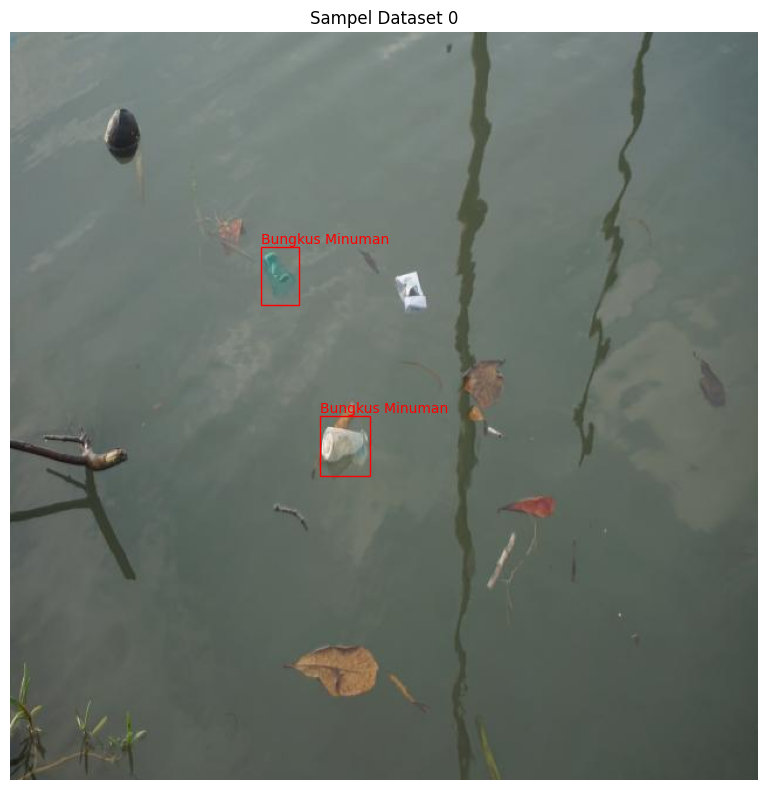

Sampel 1 - Bounding box: tensor([270.0000, 351.0000, 353.5000, 437.0000]), Label: 1, Nama Kelas: Botol Plastik


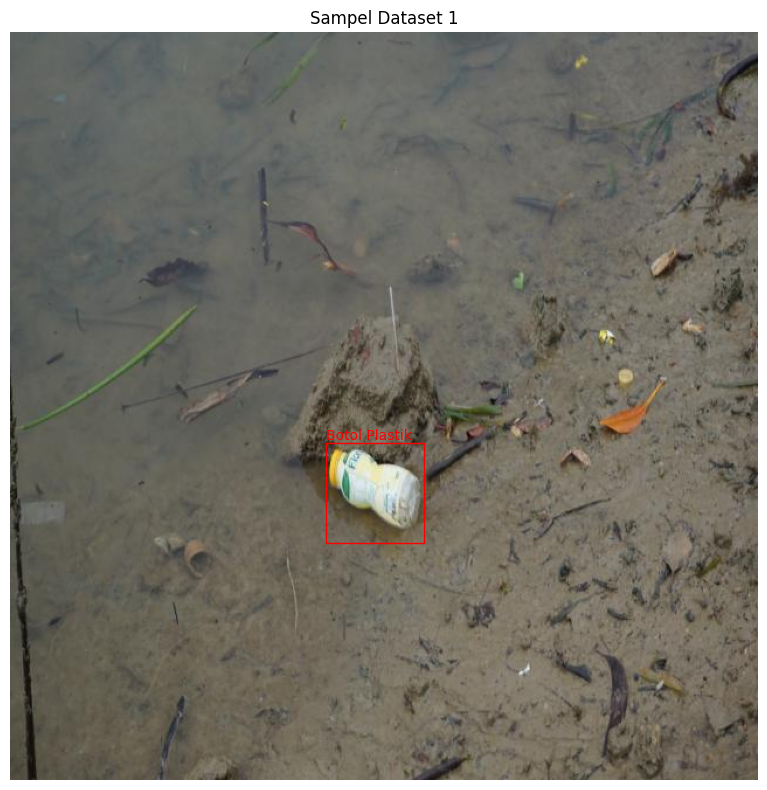

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 156MB/s]



Epoch 1/50
Training Model
Epoch: [1]  [ 0/80]  eta: 0:06:01  lr: 0.000136  loss: 1.2175 (1.2175)  loss_classifier: 1.0111 (1.0111)  loss_box_reg: 0.1781 (0.1781)  loss_objectness: 0.0245 (0.0245)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 4.5130  data: 0.0614  max mem: 7206
Epoch: [1]  [10/80]  eta: 0:02:05  lr: 0.001401  loss: 0.9525 (0.9009)  loss_classifier: 0.4555 (0.6064)  loss_box_reg: 0.2215 (0.2143)  loss_objectness: 0.0555 (0.0695)  loss_rpn_box_reg: 0.0074 (0.0107)  time: 1.7999  data: 0.0904  max mem: 7365
Epoch: [1]  [20/80]  eta: 0:01:40  lr: 0.002666  loss: 0.6282 (0.7406)  loss_classifier: 0.3422 (0.4632)  loss_box_reg: 0.2123 (0.2114)  loss_objectness: 0.0326 (0.0585)  loss_rpn_box_reg: 0.0055 (0.0075)  time: 1.5297  data: 0.0888  max mem: 7365
Epoch: [1]  [30/80]  eta: 0:01:21  lr: 0.003930  loss: 0.5192 (0.6594)  loss_classifier: 0.2290 (0.3812)  loss_box_reg: 0.2123 (0.2215)  loss_objectness: 0.0259 (0.0491)  loss_rpn_box_reg: 0.0046 (0.0076)  time: 1.5416  data: 0.0

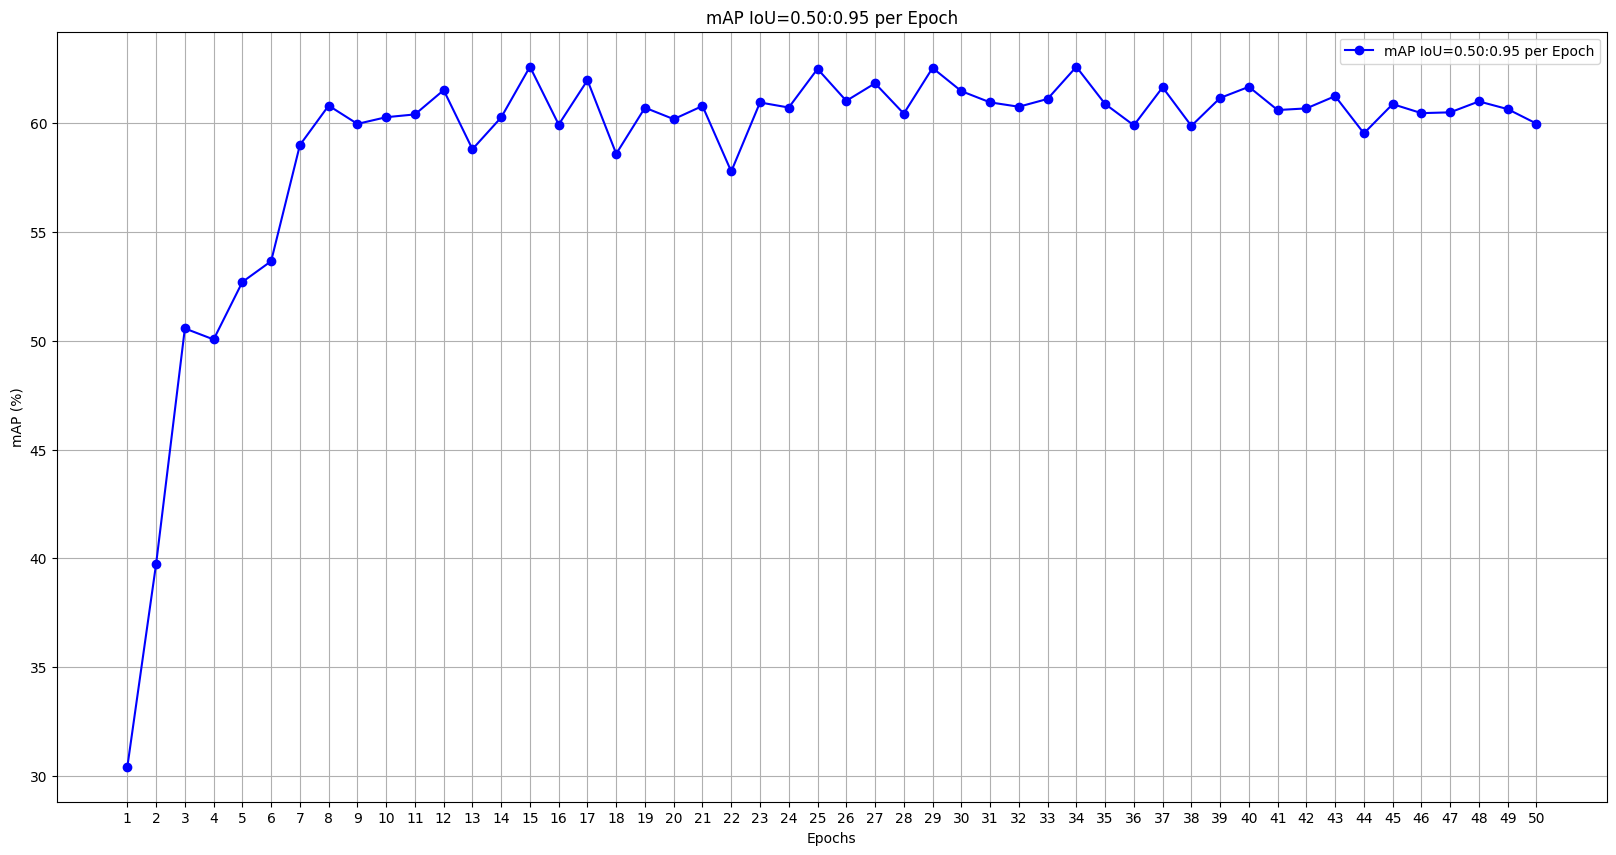

Gambar Plot mAP IoU=0.50 per Epoch


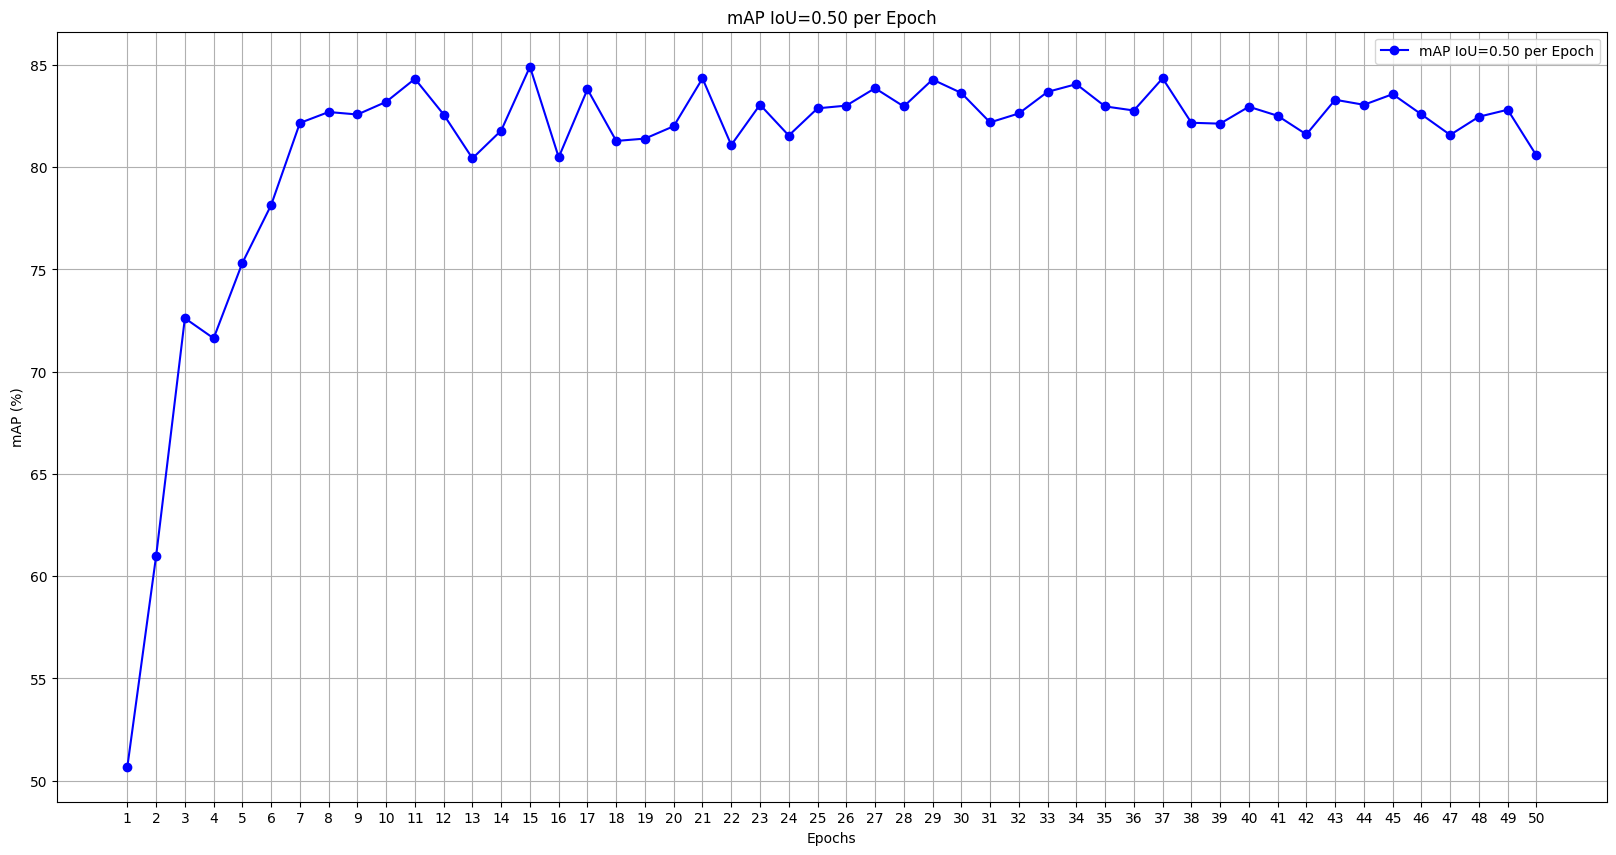

Gambar Plot Loss


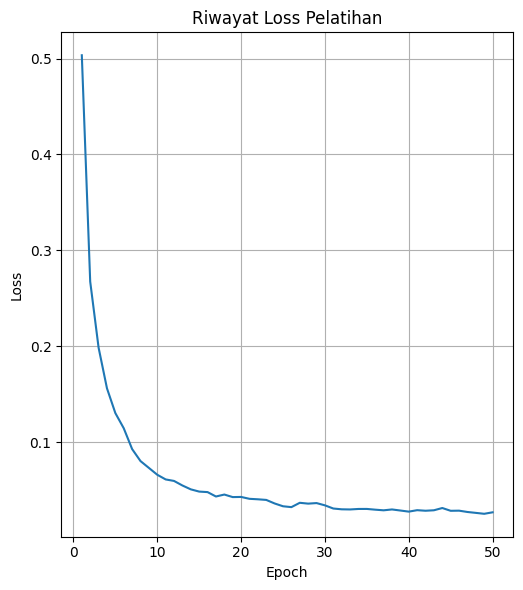

In [13]:
if __name__ == "__main__":
    main()